## **Linear Regression from Scratch**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

This function creates synthetic data with various noise patterns and characteristics, perfect for testing regression models.

In [5]:
def generate_data(n_samples=100, base_noise=2.0):
    """
    Generate random data with various types of noise and patterns
    """
    X = np.concatenate([
        np.random.normal(-3, 0.5, (n_samples//4, 1)),  # Cluster around -3
        np.random.normal(0, 1, (n_samples//4, 1)),     # Cluster around 0
        np.random.normal(2, 0.7, (n_samples//4, 1)),   # Cluster around 2
        np.random.uniform(-5, 5, (n_samples//4, 1))    # Uniform random points
    ])
    
    np.random.shuffle(X)
    
    true_coefficient = np.random.uniform(-5, 5)
    true_intercept = np.random.uniform(-10, 10)
    
    y = true_coefficient * X + true_intercept
    
    noise = (
        np.random.normal(0, base_noise, (n_samples, 1)) +  # Gaussian noise
        np.random.exponential(base_noise/2, (n_samples, 1)) +  # Asymmetric noise
        np.random.uniform(-base_noise, base_noise, (n_samples, 1))  # Uniform noise
    )
    
    outlier_idx = np.random.choice(n_samples, n_samples//10)  # 10% outliers
    noise[outlier_idx] *= 2.5
    
    seasonal = np.sin(X * 1.5) * base_noise
    
    y += noise + seasonal
    
    return X, y, true_coefficient, true_intercept

This function uses some common metrics from scipy so we can evaluate the linear regression.

In [8]:
def analyze_regression(X, y, y_pred):
    """
    Analyze the regression results and return common statistical metrics
    """
    X = X.flatten()
    y = y.flatten()
    y_pred = y_pred.flatten()
    
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    
    correlation_coef, p_value = stats.pearsonr(X, y)
    
    mse = np.mean((y - y_pred) ** 2)
    
    rmse = np.sqrt(mse)
    
    mae = np.mean(np.abs(y - y_pred))
    
    n = len(y)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - 1 - 1)
    
    return {
        'R-squared': r2,
        'Adjusted R-squared': adjusted_r2,
        'Correlation Coefficient': correlation_coef,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'P-value': p_value
    }

Now finally, this is is the *linear regression* implementation. 

### Structure

##### Initialization
- Sets learning rate (how fast to learn)
- Number of training iterations
- Initializes weights and bias to None

##### Training
- Starts with weights = 0 and bias = 0
- For each iteration:
  * Predicts y values: y = weights * X + bias
  * Calculates errors
  * Updates weights and bias to reduce errors
  * Saves the error (cost) history

##### Prediction
- Takes new X values
- Returns predictions using: y = weights * X + bias


Think of it like finding the best straight line that fits through your data points by gradually adjusting its position (weights) and height (bias) to minimize the distance between the line and the actual data points.

In [11]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.cost_history = []
        
    def fit(self, X, y):
        n_samples = X.shape[0]
        self.weights = np.zeros((1,))
        self.bias = 0
        
        y = y.reshape(-1, 1)
        X = X.reshape(-1, 1)
        
        for _ in range(self.n_iterations):
            y_predicted = np.dot(X, self.weights.reshape(-1, 1)) + self.bias
            
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)
            
            self.weights = self.weights - self.learning_rate * dw.flatten()
            self.bias = self.bias - self.learning_rate * db
            
            cost = np.mean((y_predicted - y) ** 2)
            self.cost_history.append(cost)
    
    def predict(self, X):
        X = X.reshape(-1, 1)
        return np.dot(X, self.weights.reshape(-1, 1)) + self.bias

Training and testing the model.

In [14]:
X, y, true_coef, true_intercept = generate_data(n_samples=500, base_noise=3.0)

model = LinearRegression(learning_rate=0.01, n_iterations=1000)
model.fit(X, y)

X_test = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X)

metrics = analyze_regression(X, y, y_train_pred)

#### Visualize regression results

Plot the raw data, fitted line, training progress, and model diagnostics. Compare true vs learned coefficients and display key regression metrics.

**Residuals** are the differences between the actual observed values (y) and the values predicted by the regression line (ŷ). They show how far off each prediction is from reality - basically the prediction errors.

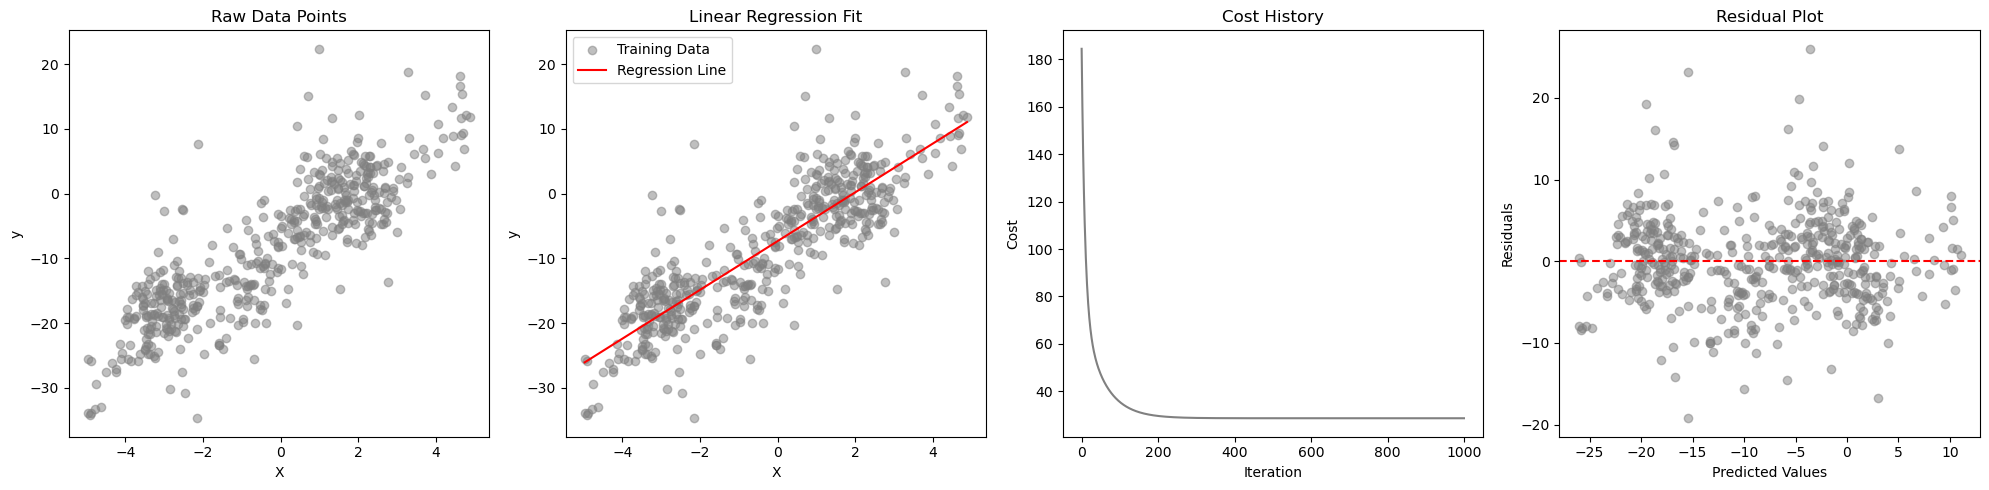


True Relationship: y = 3.96x + -9.59
Learned Relationship: y = 3.77x + -7.34

Regression Metrics:
R-squared: 0.740
Adjusted R-squared: 0.739
Correlation Coefficient: 0.860
MSE: 28.599
RMSE: 5.348
MAE: 3.992
P-value: 0.000


In [17]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.scatter(X, y, color='gray', alpha=0.5)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Raw Data Points')

plt.subplot(1, 4, 2)
plt.scatter(X, y, color='gray', alpha=0.5, label='Training Data')
plt.plot(X_test, y_pred, color='red', label='Regression Line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression Fit')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(model.cost_history, color='gray')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')

plt.subplot(1, 4, 4)
residuals = y - y_train_pred.reshape(-1, 1)
plt.scatter(y_train_pred, residuals, alpha=0.5, color='gray')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

print("\nTrue Relationship: y = {:.2f}x + {:.2f}".format(true_coef, true_intercept))
print("Learned Relationship: y = {:.2f}x + {:.2f}".format(model.weights[0], model.bias))
print("\nRegression Metrics:")
for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

Now we load and test the model on a benchmark dataset(California Housing), providing comparative performance metrics.

In [20]:
from sklearn.datasets import fetch_california_housing 

housing = fetch_california_housing()
X = housing.data[:, 0].reshape(-1, 1)  # Using median income as feature
y = housing.target.reshape(-1, 1)  # House prices

def normalize_data(X):
    """Normalize features using min-max scaling"""
    return (X - X.min()) / (X.max() - X.min())

def train_test_split(X, y, test_size=0.2, random_state=42):
    """Split data into training and testing sets"""
    np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_size = int(test_size * len(X))
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

In [22]:
X_normalized = normalize_data(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y)

model = LinearRegression(learning_rate=0.01, n_iterations=1000)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_metrics = analyze_regression(X_train, y_train, y_train_pred)
test_metrics = analyze_regression(X_test, y_test, y_test_pred)

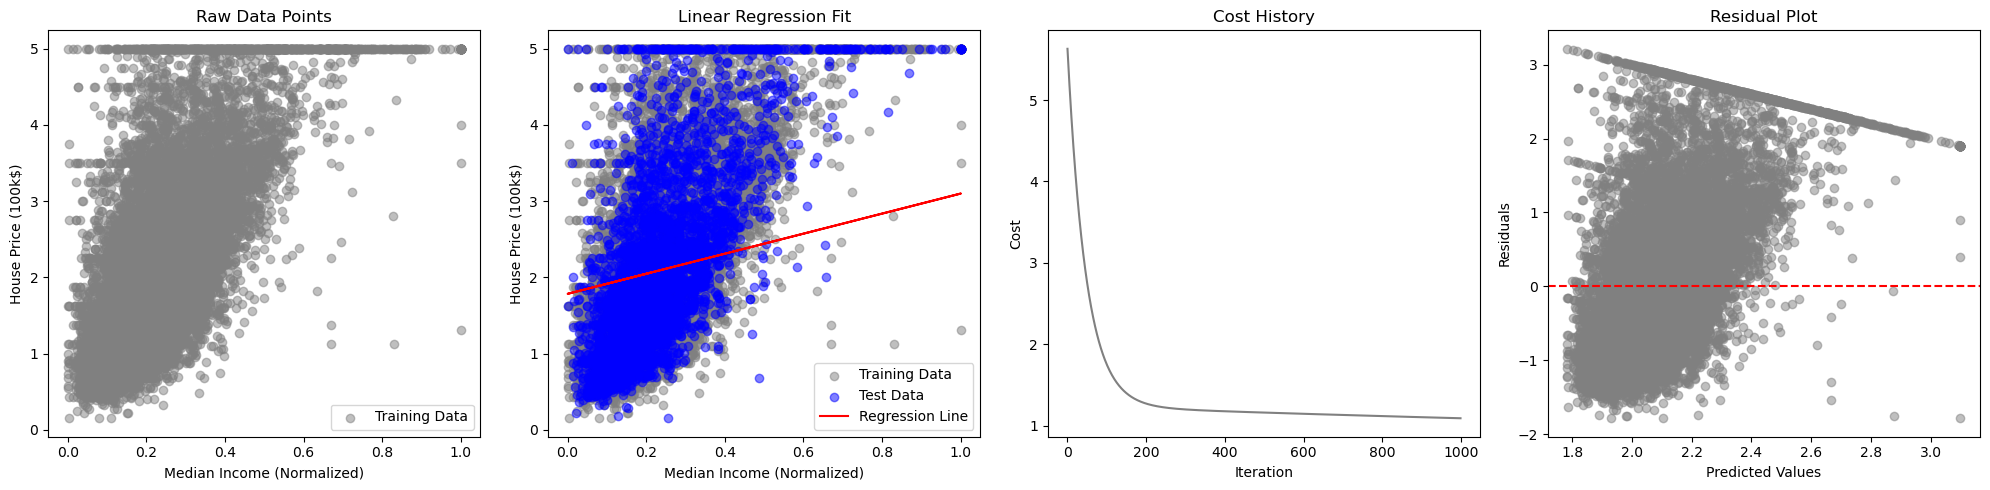


Training Set Metrics:
R-squared: 0.184
Adjusted R-squared: 0.184
Correlation Coefficient: 0.691
MSE: 1.091
RMSE: 1.044
MAE: 0.829
P-value: 0.000

Test Set Metrics:
R-squared: 0.179
Adjusted R-squared: 0.179
Correlation Coefficient: 0.678
MSE: 1.076
RMSE: 1.037
MAE: 0.822
P-value: 0.000


In [24]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.scatter(X_train, y_train, color='gray', alpha=0.5, label='Training Data')
plt.xlabel('Median Income (Normalized)')
plt.ylabel('House Price (100k$)')
plt.title('Raw Data Points')
plt.legend()

plt.subplot(1, 4, 2)
plt.scatter(X_train, y_train, color='gray', alpha=0.5, label='Training Data')
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Test Data')
plt.plot(X_test, y_test_pred, color='red', label='Regression Line')
plt.xlabel('Median Income (Normalized)')
plt.ylabel('House Price (100k$)')
plt.title('Linear Regression Fit')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(model.cost_history, color='gray')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')

plt.subplot(1, 4, 4)
residuals = y_train - y_train_pred.reshape(-1, 1)
plt.scatter(y_train_pred, residuals, alpha=0.5, color='gray')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

print("\nTraining Set Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.3f}")

print("\nTest Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.3f}")